In [1]:
import math
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
import numpy as np
from decimal import Decimal
from math import log10

[Matteo-Device:90464] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.Matteo-Device.1000/jf.0/1820393472/shared_mem_cuda_pool.Matteo-Device could be created.
[Matteo-Device:90464] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [2]:
fuel=openmc.Material(name='fuel')
fuel.add_nuclide('Pu238',2.332,'wo')
fuel.add_nuclide('Pu239',56.873,'wo')
fuel.add_nuclide('Pu240',26.997,'wo')
fuel.add_nuclide('Pu241',6.105,'wo')
fuel.add_nuclide('Pu242',7.693,'wo')
fuel.add_nuclide('U234',0.003,'wo')
fuel.add_nuclide('U235',0.404,'wo')
fuel.add_nuclide('U236',0.010,'wo')
fuel.add_nuclide('U238',99.583,'wo')
fuel.set_density("g/cc", 11)
fuel.depletable=True
#fuel.temperature=2500 #Kelvin


clad=openmc.Material(name='clad')
clad.add_element('Cr',15.0,'wo')
clad.add_element('Ni',15.0,'wo')
clad.add_element('Mo',1.5,'wo')
clad.add_element('Mn',1.5,'wo')
clad.add_element('Si',0.9,'wo')
clad.add_element('Ti',0.4,'wo')
clad.add_element('C',0.09,'wo')
clad.set_density("g/cc",5)
clad.depletable=True
#clad.temperature=900 #Kelvin

LM=openmc.Material(name='LM')
LM.add_element("Pb",1)
LM.set_density('g/cm3', 10.0)
#LM.temperature=900 #Kelvin

mats=openmc.Materials((fuel,clad,LM))
mats.export_to_xml()

In [3]:
radii=[0.45,0.57]
r_pin = [openmc.ZCylinder(r=r) for r in radii]
r_big_pin = [openmc.ZCylinder(r=r) for r in radii]
print(np.shape(r_pin))

(2,)


In [4]:

#r_pin=openmc.ZCylinder(r=0.45)
fuel_cell=openmc.Cell(fill=fuel, region=-r_pin[0])
#clad_cell=openmc.Cell(fill=clad, region=(-r_pin[0]<r)&(r>+r_pin))
LM_cell=openmc.Cell(fill=LM , region=+r_pin[1])
pin_universe=openmc.Universe(cells=(fuel_cell, LM_cell,))

r_big_pin = openmc.ZCylinder(r=0.57)
#fuel2_cell=openmc.Cell(fill=fuel, region=-r_big_pin[0])
clad2_cell = openmc.Cell(fill=clad, region=-r_big_pin)
LM2_cell = openmc.Cell(fill=LM, region=+r_big_pin)
big_pin_universe = openmc.Universe(cells=(clad2_cell, LM2_cell))

all_LM_cell=openmc.Cell(fill=LM)
outer_universe=openmc.Universe(cells=(all_LM_cell,))

In [5]:
lat=openmc.HexLattice()

In [6]:
lat.center=(0.,0.)
lat.pitch=(1.26,)
lat.outer=outer_universe

In [7]:
print(lat.show_indices(3))

            (0, 0)
      (0,11)      (0, 1)
(0,10)      (1, 0)      (0, 2)
      (1, 5)      (1, 1)
(0, 9)      (2, 0)      (0, 3)
      (1, 4)      (1, 2)
(0, 8)      (1, 3)      (0, 4)
      (0, 7)      (0, 5)
            (0, 6)


In [8]:
outer_rig=[big_pin_universe]+[pin_universe]*17
middle_rig=[big_pin_universe]+[pin_universe]*11
inner_rig = [big_pin_universe] + [pin_universe] * 5
center_rig=[big_pin_universe]
lat.universes=[outer_rig,middle_rig,inner_rig,center_rig]
print(lat)

HexLattice
	ID             =	4
	Name           =	
	Orientation    =	y
	# Rings        =	4
	# Axial        =	None
	Center         =	(0.0, 0.0)
	Pitch          =	(1.26,)
	Outer          =	3
	Universes      
   2
  1 1
 1 2 1
1 1 1 1
 1 2 1
1 1 1 1
 1 2 1
1 1 1 1
 1 1 1
1 1 1 1
 1 1 1
  1 1
   1


In [9]:
outer_surface=openmc.ZCylinder(r=6,boundary_type='vacuum')
main_cell=openmc.Cell(fill=lat, region=-outer_surface)
geom=openmc.Geometry([main_cell])
geom.export_to_xml()

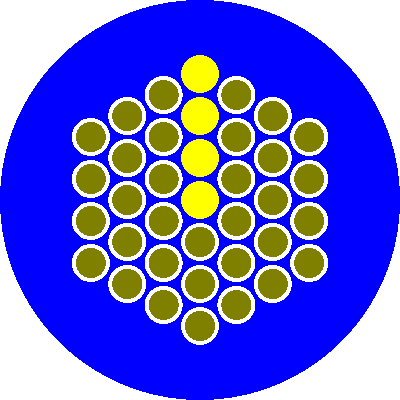

In [10]:
p=openmc.Plot.from_geometry(geom)
p.color_by='material'
p.colors = colors = {
    LM: 'blue',
    fuel: 'olive',
    clad: 'yellow'
}
p.to_ipython_image()

In [11]:
# Change the orientation of the lattice and re-export the geometry
lat.orientation = 'x'
geom.export_to_xml()

# Run OpenMC in plotting mode
#p.to_ipython_image()

/home/orion/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/model/funcs.py:124: FutureWarning: The hexagonal_prism(...) function has been replaced by the HexagonalPrism(...) class. Future versions of OpenMC will not accept hexagonal_prism.
  warn("The hexagonal_prism(...) function has been replaced by the "


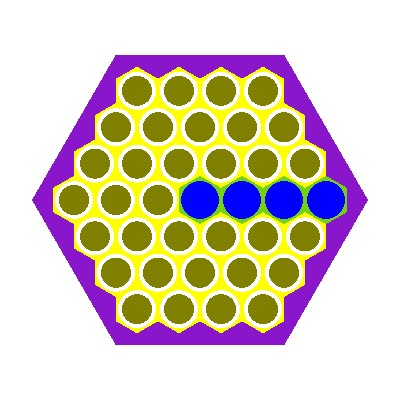

In [12]:
main_cell.region = openmc.model.hexagonal_prism(
    edge_length=4*lat.pitch[0],
    orientation='x',
    boundary_type='vacuum'
)
geom.export_to_xml()

# Run OpenMC in plotting mode
p.color_by = 'cell'
p.to_ipython_image()

In [13]:
settings = openmc.Settings()
settings.particles = 1000
settings.inactive = 10
settings.batches = 50

In [14]:
fuel.volume = math.pi * 0.45 ** 2
clad.volume = math.pi * (0.57-0.45) ** 2

In [15]:
chain = openmc.deplete.Chain.from_xml("../chain_endfb80_sfr.xml")
#chain.nuclide_dict

In [16]:
model = openmc.Model(geometry=geom, settings=settings)
operator = openmc.deplete.CoupledOperator(model, "../chain_endfb80_sfr.xml")

In [17]:
power = 210
time_steps = [30] * 6

In [18]:
integrator = openmc.deplete.PredictorIntegrator(operator, time_steps, power, timestep_units='d')

In [ ]:
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Na23 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Na23.h5
 Reading Mg24 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Mg24.h5
 Reading Mg25 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Mg25.h5
 Reading Mg26 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Mg26.h5
 Reading Al27 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Al27.h5
 Reading P31 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/P31.h5
 Reading S32 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/S32.h5
 Reading S33 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/S33.h5
 Reading S34 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/S34.h5
 Reading S36 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/S36.h5
 Reading Cl35 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cl35.h5
 Reading Cl37 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cl37.h5
 Reading Ar36 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ar36.h5
 Reading Ar38 from /home/orion/Downloads/endfb-v

 Reading K39 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/K39.h5
 Reading K40 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/K40.h5
 Reading K41 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/K41.h5
 Reading Ca40 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca40.h5
 Reading Ca42 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca42.h5
 Reading Ca43 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca43.h5
 Reading Ca44 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca44.h5
 Reading Ca46 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca46.h5
 Reading Ca48 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca48.h5
 Reading Sc45 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sc45.h5
 Reading V50 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/V50.h5
 Reading V51 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/V51.h5
 Reading Fe54 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Fe54.h5
 Reading Fe56 from /home/orion/Downloads/endfb-v

 Reading Kr78 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr78.h5
 Reading Kr80 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr80.h5
 Reading Kr82 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr82.h5
 Reading Kr83 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr83.h5
 Reading Kr84 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr84.h5
 Reading Kr85 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr85.h5
 Reading Kr86 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr86.h5
 Reading Rb85 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Rb85.h5
 Reading Rb86 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Rb86.h5
 Reading Rb87 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Rb87.h5
 Reading Sr84 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sr84.h5
 Reading Sr86 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sr86.h5
 Reading Sr87 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sr87.h5
 Reading Sr88 from /home/orion/Downloa

 Reading Tc99 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Tc99.h5
 Reading Ru96 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru96.h5
 Reading Ru98 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru98.h5
 Reading Ru99 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru99.h5
 Reading Ru100 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru100.h5
 Reading Ru101 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru101.h5
 Reading Ru102 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru102.h5
 Reading Ru103 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru103.h5
 Reading Ru104 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru104.h5
 Reading Ru105 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru105.h5
 Reading Ru106 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru106.h5
 Reading Rh103 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Rh103.h5
 Reading Rh105 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Rh105.h5
 Reading Pd102 from 

          1200K
          2500K


 Reading Cd114 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd114.h5
 Reading Cd115_m1 from
 /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd115_m1.h5
 Reading Cd116 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd116.h5
 Reading In113 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/In113.h5
 Reading In115 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/In115.h5
 Reading Sn112 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn112.h5
 Reading Sn113 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn113.h5
 Reading Sn114 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn114.h5
 Reading Sn115 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn115.h5
 Reading Sn116 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn116.h5
 Reading Sn117 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn117.h5
 Reading Sn118 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn118.h5
 Reading Sn119 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn119.h5
 Read

          1200K
          2500K


 Reading Te120 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te120.h5
 Reading Te122 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te122.h5
 Reading Te123 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te123.h5
 Reading Te124 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te124.h5
 Reading Te125 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te125.h5
 Reading Te126 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te126.h5
 Reading Te127_m1 from
 /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te127_m1.h5
 Reading Te128 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te128.h5
 Reading Te129_m1 from
 /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te129_m1.h5


          1200K
          2500K


 Reading Te130 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te130.h5
 Reading Te132 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te132.h5
 Reading I127 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/I127.h5
 Reading I129 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/I129.h5
 Reading I130 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/I130.h5
 Reading I131 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/I131.h5
 Reading I135 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/I135.h5
 Reading Xe123 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe123.h5
 Reading Xe124 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe124.h5


 Reading Xe126 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe126.h5
 Reading Xe128 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe128.h5
 Reading Xe129 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe129.h5
 Reading Xe130 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe130.h5
 Reading Xe131 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe131.h5
 Reading Xe132 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe132.h5
 Reading Xe133 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe133.h5


          2500K
          1200K
          2500K


 Reading Xe134 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe134.h5
 Reading Xe135 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe135.h5
 Reading Xe136 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe136.h5
 Reading Cs133 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cs133.h5
 Reading Cs134 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cs134.h5
 Reading Cs135 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cs135.h5
 Reading Cs136 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cs136.h5
 Reading Cs137 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cs137.h5
 Reading Ba130 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba130.h5
 Reading Ba132 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba132.h5
 Reading Ba133 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba133.h5
 Reading Ba134 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba134.h5
 Reading Ba135 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba135.h5
 Reading Ba1

          1200K
          2500K


 Reading Gd153 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd153.h5
 Reading Gd154 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd154.h5
 Reading Gd155 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd155.h5
 Reading Gd156 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd156.h5
 Reading Gd157 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd157.h5
 Reading Gd158 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd158.h5
 Reading Gd160 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd160.h5
 Reading Tb159 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Tb159.h5
 Reading Tb160 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Tb160.h5
 Reading Dy156 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Dy156.h5
 Reading Dy158 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Dy158.h5
 Reading Dy160 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Dy160.h5
 Reading Dy161 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Dy161.h5
 Reading Dy1

          1200K


 Reading Cf253 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cf253.h5
 Reading Cf254 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cf254.h5
 Reading Es251 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Es251.h5
 Reading Es252 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Es252.h5
 Reading Es253 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Es253.h5
 Reading Es254 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Es254.h5
 Reading Es254_m1 from
 /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Es254_m1.h5
 Reading Es255 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Es255.h5
 Reading Fm255 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Fm255.h5
 Maximum neutron transport energy: 8100000 eV for Be7


In [ ]:
results = openmc.deplete.Results("./depletion_results.h5")

In [ ]:
time, k = results.get_keff()

In [ ]:
time /= (24 * 60 * 60)  # convert back to days from seconds

In [ ]:
plt.errorbar(time, k[:, 0], yerr=k[:, 1])
plt.xlabel("Time [d]")
plt.ylabel("$k_{eff}\pm \sigma$");

In [ ]:
_, u235 = results.get_atoms("1", "U235")
_, xe135 = results.get_atoms("1", "Xe135")
_,he4=results.get_atoms("2","He4")
_,ni58=results.get_atoms("2","Ni58")
_,ni59=results.get_atoms("2","Ni59")
_,Fe56=results.get_atoms("2","Fe56")
_,u235=results.get_atoms("1","U235")
_,u238=results.get_atoms("1","U238")
_,pu239=results.get_atoms("1","Pu239")
_,pu238=results.get_atoms("1","Pu238")

In [ ]:
plt.plot(time, he4*100, label="He4")
plt.xlabel("Time [d]")
plt.ylabel("Number of atoms - He4");
plt.grid()

# Tallies

In [ ]:
# Neutron spectrum
tally_list = []

n_groups = 500
Emin = 1e-5
Emax = 20e6

energies = np.logspace(log10(Emin), log10(Emax), n_groups+1)

energy_filter = openmc.EnergyFilter(energies)

spectrum = openmc.Tally(name = "Neutron Spectrum")
spectrum.filters = [energy_filter]
spectrum.scores = ['flux']

tally_list.append(spectrum)

In [ ]:
tallies = openmc.Tallies(tally_list)
tallies.export_to_xml()

In [ ]:
openmc.run()

In [ ]:
sp = openmc.StatePoint('statepoint.50.h5')

In [ ]:
# Neutron spectrum
spectrum_tally = sp.get_tally(name = "Neutron Spectrum")

e_filter = spectrum_tally.filters[0]
E = e_filter.bins[:,0]

spectrum_mean = spectrum_tally.get_values(value = 'mean').ravel()
spectrum_std_dev = spectrum_tally.get_values(value = 'std_dev').ravel()

# Plot
fig, ax = plt.subplots()
plt.errorbar(E, spectrum_mean,spectrum_std_dev, ds = 'steps')
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Flux (a.u.)")
ax.grid(True, which = 'both')
#plt.savefig('./energy_flux.pdf', format='pdf', dpi = 600, bbox_inches = 'tight')

# Note
Il k-efficace è molto piccolo in quanto sto simulando un "full-core" quindi si deve raggiungere massa critica, come? con molti più fuel-assembly qui ce ne sono solamente 19 ma il core di ALFRED è fatto da 171FA, quindi questo è il motivo per cui non si è critici qui. Inoltre come boundary esterna ho praticamente "vacuum" quindi qui i neutroni li perdo!